<a href="https://colab.research.google.com/github/castillosebastian/research_tools/blob/master/TPFinal_AnalisisyProyeccionVentas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final - Aprendizaje Automático, UTN-Paraná, 2021
# Prof.Dr. Franco Ronchetti

## Título: 
**"Análisis y proyección de Ventas en XXX"**
## Alumnos:  
  - Cívico Sergio 
  - Shai Blejar
  - Castillo Claudio Sebastian

# Revisión Bibliográfica y Recursos
- Predicting Future Sales of Retail Products using Machine Learning
Devendra Swami, Alay Dilipbhai Shah, Subhrajeet K B Ray, https://arxiv.org/pdf/2008.07779.pdf
- Demand forecasting: Using machine learning to predict retail sales,Pascal Coggia and  Jérôme Petit, TECHNATIVE, agosto 2021, https://technative.io/demand-forecasting-machine-learning-retail-sales/. 
- Facebook Prophet, open-sourced by Facebook research, ejemplo implementación en: https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts 
- Retail sales forecast,ALBERTO REMOTO, on Kaggle: https://www.kaggle.com/aremoto/retail-sales-forecast
- Playground Prediction Competition: Predict Future Sales, on Kaggle, https://www.kaggle.com/c/competitive-data-science-predict-future-sales/code?competitionId=8587&sortBy=voteCount&language=Python
- Encoding de variables categóricas: https://pbpython.com/categorical-encoding.html 

# Modelos de datasets

The target variable, or predictor, is: **Sales** (if forecast: sales of the next period). 
1. Day of the month.
2. Month.
3. Day of the week.
4. Promotion.
5. State holidays.
6. School holidays.
7. Sales of the 7 previous days.
8. Promotions of the 7 previous days.

Otros datos importante
9. Price
10. Location
11. Sales done on a day for an item




# Fuentes

- Ventas Minoristas: Australian Bureau of Statistics, Retail Trade, Australia Monthly and quarterly estimates of turnover and volumes for retail businesses, including store and online sales. Reference period October 2021. 
    + Table 1. Retail turnover, by industry group: https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-trade-australia/oct-2021/850101.xls
    + Table 3. Retail turnover, by state: https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-trade-australia/oct-2021/850103.xls 







# Paquetes y herramientas de análisis

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
import os
import nltk

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# machine learning
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

# others
import bs4
import io
import requests
from google.colab import drive
import json

# initialize some package settings
sns.set(style="whitegrid", color_codes=True, font_scale=1.3)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
%cd  'drive/My Drive/Colab Notebooks/data'

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
%ls

corpus_fallosmetdat.json  reorder_buyer  sales2020.csv    tbfallos.json
corpus_textosfallos.json  sales2018.csv  sales2021.csv    tbmetdat.json
Libro1.csv                sales2019.csv  tbdoctrina.json


# Presentación del Dataset de análisis

In [ ]:
sales2018 = pd.read_csv("sales2018.csv", sep= ";", header=0, encoding='latin-1', skip_blank_lines=True)
#sales2019 = pd.read_csv("sales2019.csv", sep= ";", header=0, encoding='latin-1', skip_blank_lines=True) #roto
sales2020 = pd.read_csv("sales2020.csv", sep= ";", header=0, encoding='latin-1')
#sales2021 = pd.read_csv('sales2021.csv', sep= ";", header=0, encoding='latin-1', skip_blank_lines=True) # roto

In [ ]:
frames = [sales2018, sales2020] # sales2018, sales2021
sales = pd.concat(frames, axis=0)

In [ ]:
sales.shape

(412438, 71)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412438 entries, 0 to 226158
Data columns (total 71 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   db_source         412438 non-null  int64  
 1   so_order_no       412438 non-null  object 
 2   so_bo_suffix      339554 non-null  object 
 3   so_cust_code      412438 non-null  object 
 4   so_order_date     412438 non-null  object 
 5   so_delivery_date  412438 non-null  object 
 6   MTH               412438 non-null  int64  
 7   WEEK              412438 non-null  int64  
 8   WEEKDAY           412438 non-null  object 
 9   DAY               412438 non-null  object 
 10  FISCAL YEAR       412438 non-null  object 
 11  YEAR              412438 non-null  object 
 12  delivery_date     412438 non-null  object 
 13  order_packages    412438 non-null  object 
 14  so_order_weight   412438 non-null  object 
 15  job_code          330931 non-null  object 
 16  so_order_status   41

In [ ]:
sales.head()

,db_source,so_order_no,so_bo_suffix,so_cust_code,so_order_date,so_delivery_date,MTH,WEEK,WEEKDAY,DAY,FISCAL YEAR,YEAR,delivery_date,order_packages,so_order_weight,job_code,so_order_status,reason_code,order_type_code,so_whse_code,territory_code,STORE,so_cust_type,so_rep_code,tax_exemption_no,so_terms_disc,so_price_code,cust_reference,so_invoice_no,credit_note_no,so_invoice_date,processing_date,total_amount,total_tax_adj,shipped_tax_adj,total_charges,so_curr_code,so_user_id_code,so_order_source,spare_alpha2_2,tax_calc_level,so_store_id,so_terminal,so_operator_code,pos_process,so_dif_flag,so_document_no,so_bo_suffix2,sol_line_seq,reorder_buyer,stk_description,stk_desc_line_2,stk_desc_line_3,sol_ordered_qty,sol_line_amount,stk_description3,stock_code,stock_code4,sys_description,stk_stock_status,stock_group,Status,Sales no GST,Month Proc,rep,STATE,Year proc,returns,Month proc2,Reord_buy_Cat,Subcategory
0,2,547281,203262,14/1/2018,10/2/2018,1,28,7,domingo,2021-2022,2018,10/2/2018,4,0,90,1211,211,SG & JL Hornsby,R,J,R0,547281,0,10/2/2018,10/2/2018,1720.74,0,0,0,pos1211,3,M,L,1211,1,J,14/1/2018 05:33,0,5,22,Sleepmaker Lifestyle,Firm Mattress (R-Out Fabric),Single,1,312.78,Sleepmaker Lifestyle,281023001,281023001,SG Mattress,I,9000,Finished,284.3454545,2,Halina Domeika,NSW,2018,sale,2,Others,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,553318,259196,4/2/2018,17/2/2018,2,31,7,domingo,2021-2022,2018,17/2/2018,1,0,90,2200,206,SG Castle Hill,R,R0,553318,0,19/2/2018,19/2/2018,404,0,0,0,pos1206,3,M,L,1206,1,38,4/2/2018 00:53,0,1,22,Sleepmaker Lifestyle,Firm Mattress (R-Out Fabric),Single,1,329,Sleepmaker Lifestyle,281023001,281023001,SG Mattress,I,9000,Finished,299.0909091,2,Default-User,NSW,2018,sale,2,Others,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,568569,AA,266405,2/4/2018,3/4/2018,4,40,1,lunes,2021-2022,2018,3/4/2018,2,18.5,90,1227,227,SG & JL Liverpool,R,63,R0,568569,0,3/4/2018,3/4/2018,410,0,0,0,pos1227,3,M,L,1227,1,63,2/4/2018 01:36,568569,AA,1,22,Sleepmaker Lifestyle,Firm Mattress (R-Out Fabric),Single,1,230,Sleepmaker Lifestyle,281023001,281023001,SG Mattress,I,9000,Finished,209.0909091,4,Nicole De Martin,NSW,2018,sale,4,Others,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,635206,298785,28/10/2018,28/10/2018,10,17,7,domingo,2021-2022,2018,28/10/2018,3,0,90,1223,223,SG & JL Penrith Clearance,R,138,R0,635206,0,28/10/2018,28/10/2018,480,0,0,0,pos1223,3,M,L,1223,1,138,28/10/2018 00:29,635206,2,22,Sleepmaker Lifestyle,Firm Mattress (R-Out Fabric),Single,2,160,Sleepmaker Lifestyle,281023001,281023001,SG Mattress,I,9000,Finished,145.4545455,10,Alex Ryder,NSW,2018,sale,10,Others,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,635686,298785,29/10/2018,0/1/1900,10,18,1,lunes,2021-2022,2018,28/10/2018,1,0,90,7,1223,223,SG & JL Penrith Clearance,R,138,R0,635206,9526,28/10/2018,29/10/2018,-80,0,0,0,jennik,3,M,L,1223,1,138,28/10/2018 00:29,635206,2,22,Sleepmaker Lifestyle,Firm Mattress (R-Out Fabric),Single,-1,-80,Sleepmaker Lifestyle,281023001,281023001,SG Mattress,I,9000,Finished,-72.72727273,10,Alex Ryder,NSW,2018,return,10,Others,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sales.so_order_date.value_counts()

26/12/2020    1966
28/6/2020     1835
27/6/2020     1706
21/6/2020     1631
29/11/2020    1620
              ... 
31/8/2019        1
1/8/2019         1
23/7/2019        1
29/4/2019        1
27/6/2019        1
Name: so_order_date, Length: 870, dtype: int64

In [ ]:
sales["so_order_date"] = pd.to_datetime(sales["so_order_date"], errors = 'coerce')
sales["so_delivery_date"] = pd.to_datetime(sales["so_delivery_date"], errors = 'coerce')

In [ ]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [ ]:
missing_values_table(sales)

Your selected dataframe has 71 columns.
There are 38 columns that have missing values.


,Missing Values,% of Total Values
STATE,85777,20.8
reason_code,82291,20.0
rep,81666,19.8
order_type_code,81590,19.8
Subcategory,81507,19.8
tax_exemption_no,81507,19.8
Year proc,81507,19.8
so_terms_disc,81507,19.8
returns,81507,19.8
Month proc2,81507,19.8


## Muchos valores nulos

El dataset tiene muchos nulos, si se eliminan se pierde el 40%+. Ojo que so_delibery_date tiene el 20% valores nulos!

In [ ]:
#sales = sales.dropna('index')

In [ ]:
# missing_values_table(sales)

In [ ]:
sales.shape

(412438, 71)

In [ ]:
ts = sales['so_order_date'].value_counts().sort_index()

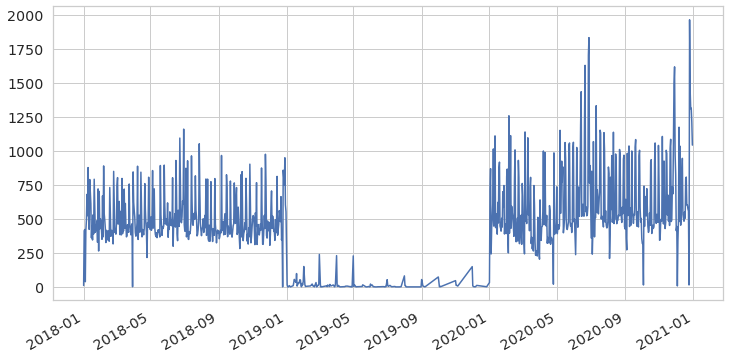

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,6))
ts.plot()

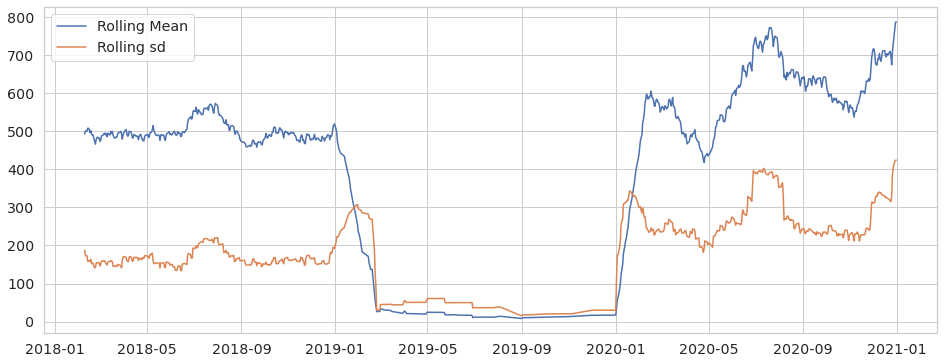

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=40,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=40,center=False).std(),label='Rolling sd');
plt.legend();

## Hay estacionalidad y podría a marcarse cierta tendencia ascendente

<Figure size 1440x1152 with 0 Axes>

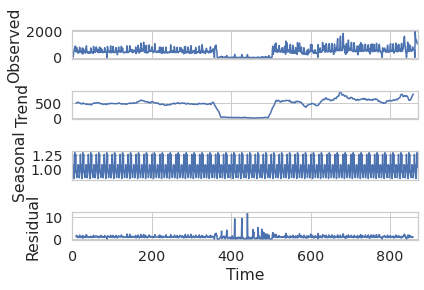

In [ ]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=20,model="multiplicative")
plt.figure(figsize=(20,16))
fig = res.plot()

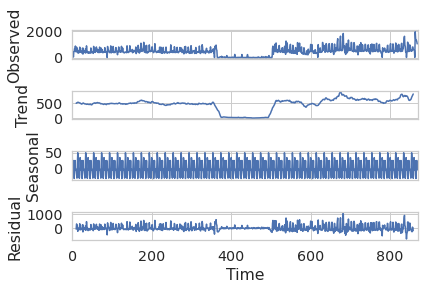

In [ ]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=20,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [ ]:
stores = sales.groupby(["STORE"]).size()
fig1, ax1 = plt.subplots(figsize=(12,6))
stores.plot.bar()

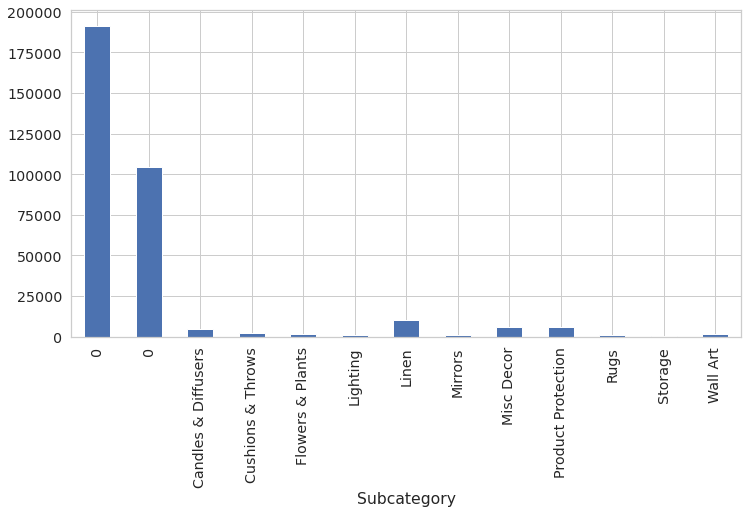

In [ ]:
subcat = sales.groupby(["Subcategory"]).size()
fig1, ax1 = plt.subplots(figsize=(12,6))
subcat.plot.bar()

In [ ]:
sales.groupby('stock_group').size().reset_index(name='Count').sort_values(['Count'], ascending=False)

,stock_group,Count
96,YDCH,102024
104,0,31049
54,4012,14435
17,1005,12817
101,ZSER,12729
...,...,...
131,3010,1
130,3009,1
125,2019,1
107,1006,1


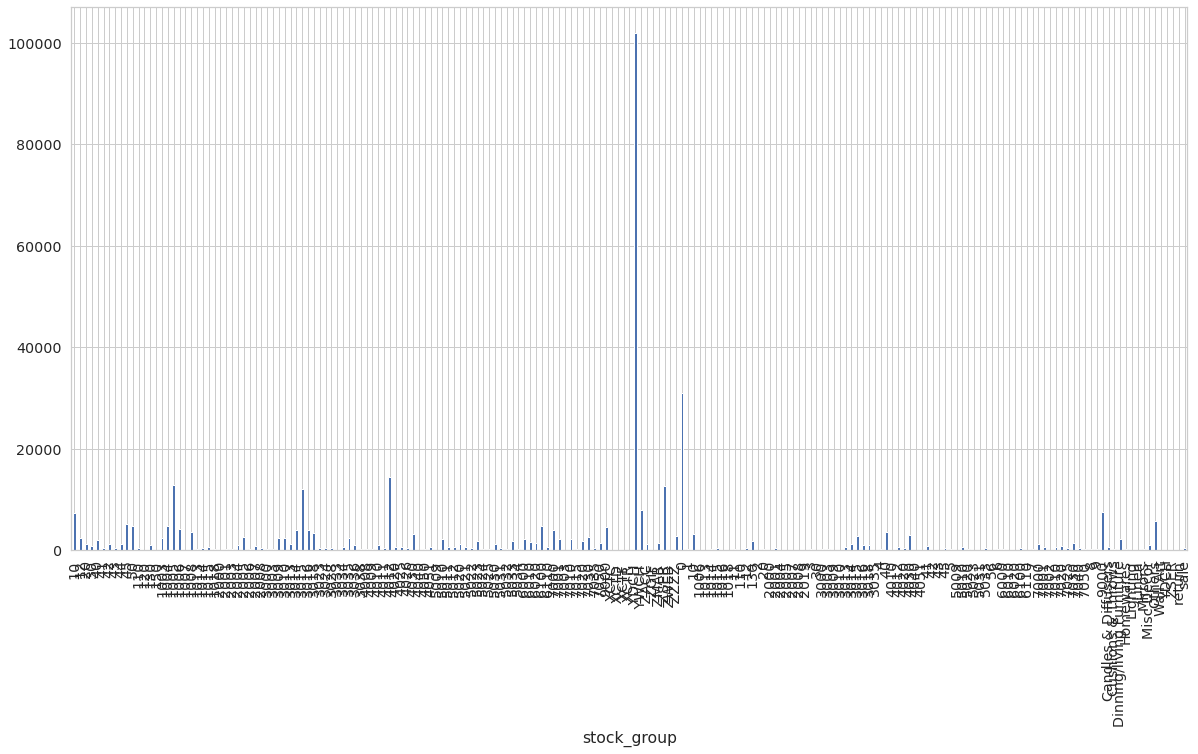

In [ ]:
stores = sales.groupby(["stock_group"]).size()
fig1, ax1 = plt.subplots(figsize=(20,10))
stores.plot.bar()

# Exploración de otras variables

In [ ]:
sales.groupby('stock_code').size().reset_index(name='Count').sort_values(['Count'], ascending=False)

,stock_code,Count
1135,YDELIVERYSMALL,23429
0,1.11071e+11,16384
1132,YDELIVERYLARGE,10201
1145,1.11071E+11,7774
2224,3.0131E+11,5829
...,...,...
1184,1070608018,1
1905,132TOO160380CHA,1
1185,1070637003,1
1188,1071018001,1


In [ ]:
sales.groupby('so_user_id_code').size().reset_index(name='Count').sort_values(['Count'], ascending=False)

,so_user_id_code,Count
39,pos1205,7334
47,pos1227,5898
40,pos1206,5729
42,pos1208,5050
80,pos5215,4822
...,...,...
99,danae.carly@hotmail.com,1
107,jaclynp@iinet.net.au,1
109,jeffreychikhonglim@gmail.com,1
112,karla@changesuccess.com.au,1


In [ ]:
sales.groupby('so_order_source').size().reset_index(name='Count').sort_values(['Count'], ascending=False)

,so_order_source,Count
4,3,203440
2,S,8525
1,P,5257
5,8,3431
6,P,2758
7,S,2698
3,0,48
0,-,2


In [ ]:
sales.groupby('sol_line_seq').size().reset_index(name='Count').sort_values(['Count'], ascending=False)

,sol_line_seq,Count
208,1,41435
6,1,37891
17,2,25095
230,2,21658
28,3,15522
...,...,...
154,70,1
234,2.3,1
155,71,1
156,72,1


In [ ]:
sales.groupby('reorder_buyer').size().reset_index(name='Count').sort_values(['Count'], ascending=False)

,reorder_buyer,Count
1,7,128966
7,27,62705
13,39,33210
834,S,33070
5,22,30829
...,...,...
428,132STO150050LIC,1
427,132STO150050DAC,1
424,132SERQUEBEDBRW,1
421,132SAVQUEBEDCOM,1


# Agrego feature externos: ventas_minoristas de Australia



In [ ]:
from pandas import read_excel
my_sheet = 'Data1' 
file = 'https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-trade-australia/oct-2021/850101.xls'
df = read_excel(file, sheet_name = my_sheet, usecols=[0,1,2,3,4,5,6,7])            

In [ ]:
df = df.iloc[9:,]

In [ ]:
df.head()

,Unnamed: 0,Turnover ; Total (State) ; Food retailing ;,Turnover ; Total (State) ; Household goods retailing ;,"Turnover ; Total (State) ; Clothing, footwear and personal accessory retailing ;",Turnover ; Total (State) ; Department stores ;,Turnover ; Total (State) ; Other retailing ;,"Turnover ; Total (State) ; Cafes, restaurants and takeaway food services ;",Turnover ; Total (State) ; Total (Industry) ;
9,1982-04-01 00:00:00,1162.6,592.3,359.9,460.1,479.1,342.4,3396.4
10,1982-05-01 00:00:00,1150.9,629.6,386.6,502.6,486.1,342.1,3497.9
11,1982-06-01 00:00:00,1160,607.4,350.5,443.8,467.5,328.7,3357.8
12,1982-07-01 00:00:00,1206.4,632.4,359.3,459.1,491.1,338.5,3486.8
13,1982-08-01 00:00:00,1152.5,622.6,325.2,438.4,485.7,331.5,3355.9


In [ ]:
ventas_minoristas = df

In [ ]:
ventas_minoristas.columns = ['dates', 'food', 'household_goods', 'clothing', 'department_stores', 'other', 'restaurants_takeaw_food', 'industry']

In [ ]:
ventas_minoristas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 9 to 483
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dates                    475 non-null    object
 1   food                     475 non-null    object
 2   household_goods          475 non-null    object
 3   clothing                 475 non-null    object
 4   department_stores        475 non-null    object
 5   other                    475 non-null    object
 6   restaurants_takeaw_food  475 non-null    object
 7   industry                 475 non-null    object
dtypes: object(8)
memory usage: 29.8+ KB


In [ ]:
ventas_minoristas['dates'] = pd.to_datetime(ventas_minoristas['dates'])
ventas_minoristas['food'] = pd.to_numeric(ventas_minoristas['food'],errors = 'coerce')
ventas_minoristas['household_goods'] = pd.to_numeric(ventas_minoristas['household_goods'],errors = 'coerce')
ventas_minoristas['clothing'] = pd.to_numeric(ventas_minoristas['clothing'],errors = 'coerce')
ventas_minoristas['department_stores'] = pd.to_numeric(ventas_minoristas['department_stores'],errors = 'coerce')
ventas_minoristas['other'] = pd.to_numeric(ventas_minoristas['other'],errors = 'coerce')
ventas_minoristas['restaurants_takeaw_food'] = pd.to_numeric(ventas_minoristas['restaurants_takeaw_food'],errors = 'coerce')
ventas_minoristas['industry'] = pd.to_numeric(ventas_minoristas['industry'],errors = 'coerce')
ventas_minoristas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 9 to 483
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   dates                    475 non-null    datetime64[ns]
 1   food                     475 non-null    float64       
 2   household_goods          475 non-null    float64       
 3   clothing                 475 non-null    float64       
 4   department_stores        475 non-null    float64       
 5   other                    475 non-null    float64       
 6   restaurants_takeaw_food  475 non-null    float64       
 7   industry                 475 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 29.8 KB


In [ ]:
ventas_minoristas.head()


,dates,food,household_goods,clothing,department_stores,other,restaurants_takeaw_food,industry
9,1982-04-01,1162.6,592.3,359.9,460.1,479.1,342.4,3396.4
10,1982-05-01,1150.9,629.6,386.6,502.6,486.1,342.1,3497.9
11,1982-06-01,1160.0,607.4,350.5,443.8,467.5,328.7,3357.8
12,1982-07-01,1206.4,632.4,359.3,459.1,491.1,338.5,3486.8
13,1982-08-01,1152.5,622.6,325.2,438.4,485.7,331.5,3355.9


Tenemos las ventas minoristas de Australia histórico 1982-1921 por industria, inluye household_goods.

# Iniciamos Modelado

Vamos a filtrar el data set para las categorías que nos interesan y filtrar features.

Filtramos observaciones de los códigos que nos interesan

In [ ]:
products_code = {7, 22, 27, 39}
df = sales.loc[sales['reorder_buyer'].isin(products_code)]

In [ ]:
df.shape

(255710, 71)

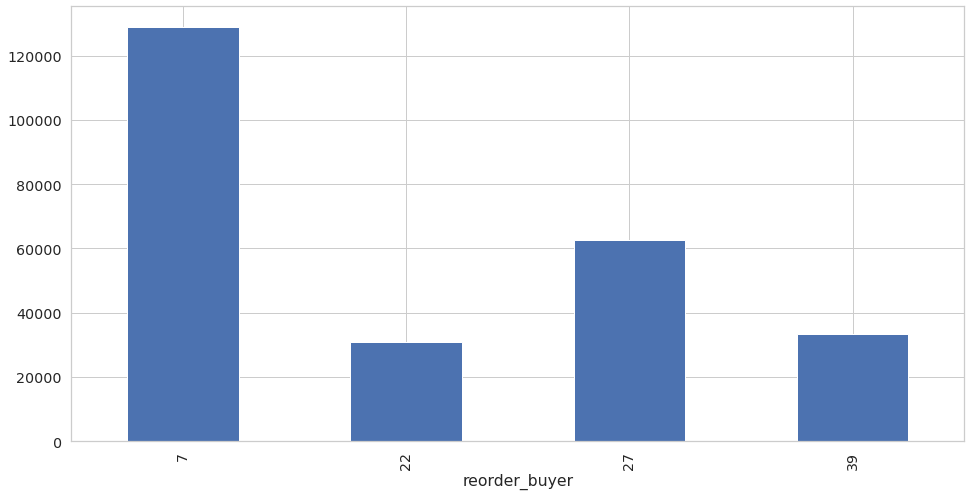

In [ ]:
categorias = df.groupby(["reorder_buyer"]).size()
fig1, ax1 = plt.subplots(figsize=(16,8))
categorias.plot.bar();

Filtramos features preseleccionados con gente del dominio

In [ ]:
df = df[['reorder_buyer', 'STORE', 'so_order_date', 'so_delivery_date', 'order_packages', 'so_order_status', 'so_invoice_no', 'sol_ordered_qty', 'sol_line_amount']]

In [ ]:
df.shape

(255710, 9)

Crear nuevos features

In [ ]:
df['dif_order_deliver'] = (df['so_delivery_date'] - df['so_order_date']).dt.days

# Corregir formato fecha

In [ ]:
df.head()

,reorder_buyer,STORE,so_order_date,so_delivery_date,order_packages,so_order_status,so_invoice_no,sol_ordered_qty,sol_line_amount,dif_order_deliver
90284,22,SG & JL Hornsby,2018-08-01,2018-01-16,4,90,545238,1,313,-197.0
90285,22,SG Auburn,2018-01-14,2018-01-31,2,90,547052,1,313,17.0
90286,22,SG & JL Hornsby,2018-01-18,2018-05-03,1,90,548130,1,329,105.0
90287,22,SG & JL Hornsby,2018-01-28,2018-01-02,4,90,551153,1,329,-26.0
90288,22,SG Auburn,2018-04-02,2018-06-02,4,90,553410,1,310,61.0


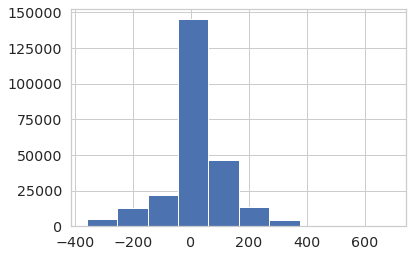

In [ ]:
df.dif_order_deliver.hist()

En el histograma podemos ver la diferencia en días corridos entre la *order_date* y la *delivery_date* que estaría asociada a la demora en la entrega del producto. El resultado es anómalo pues tiene demoras negativas, lo que implica que el producto se entregó antes que se genere la orden. Puede estar vinculado al registro de backorders, así que lo vamos a filtrar por razones de consistencia. 

In [ ]:
df = df.loc[df['dif_order_deliver'] >= 0]

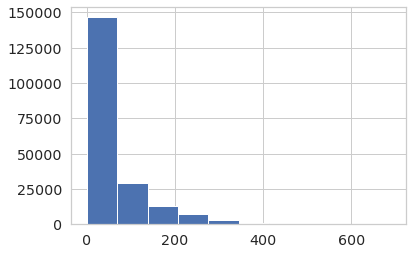

In [ ]:
df.dif_order_deliver.hist()

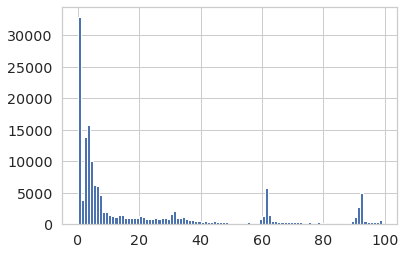

In [ ]:
df.dif_order_deliver.hist(bins= range(100))

Hay demoras muy grandes > 60 ¿puede ser?

In [ ]:
df.shape

(201107, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201107 entries, 90285 to 224174
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   reorder_buyer      201107 non-null  object        
 1   STORE              198910 non-null  object        
 2   so_order_date      201107 non-null  datetime64[ns]
 3   so_delivery_date   201107 non-null  datetime64[ns]
 4   order_packages     201107 non-null  object        
 5   so_order_status    201107 non-null  int64         
 6   so_invoice_no      201107 non-null  object        
 7   sol_ordered_qty    201107 non-null  object        
 8   sol_line_amount    201107 non-null  object        
 9   dif_order_deliver  201107 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 16.9+ MB


# Formateamos features

In [ ]:
cols = ['reorder_buyer', 'STORE', 'so_order_status', 'so_invoice_no']
df[cols] = df[cols].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201107 entries, 90285 to 224174
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   reorder_buyer      201107 non-null  category      
 1   STORE              198910 non-null  category      
 2   so_order_date      201107 non-null  datetime64[ns]
 3   so_delivery_date   201107 non-null  datetime64[ns]
 4   order_packages     201107 non-null  object        
 5   so_order_status    201107 non-null  category      
 6   so_invoice_no      201107 non-null  category      
 7   sol_ordered_qty    201107 non-null  object        
 8   sol_line_amount    201107 non-null  object        
 9   dif_order_deliver  201107 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(1), object(3)
memory usage: 17.9+ MB


In [ ]:
# error en los paquetes : Unable to parse string " -   " at position 856
# df['order_packages'] = pd.to_numeric(df['order_packages']) #

In [ ]:
df['order_packages'] = pd.to_numeric(df['order_packages'], errors='coerce').convert_dtypes()
df['sol_ordered_qty'] = pd.to_numeric(df['sol_ordered_qty'], errors='coerce').convert_dtypes()
df['sol_line_amount'] = pd.to_numeric(df['sol_line_amount'], errors='coerce').convert_dtypes()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201107 entries, 90285 to 224174
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   reorder_buyer      201107 non-null  category      
 1   STORE              198910 non-null  category      
 2   so_order_date      201107 non-null  datetime64[ns]
 3   so_delivery_date   201107 non-null  datetime64[ns]
 4   order_packages     198797 non-null  Int64         
 5   so_order_status    201107 non-null  category      
 6   so_invoice_no      201107 non-null  category      
 7   sol_ordered_qty    201107 non-null  Int64         
 8   sol_line_amount    166082 non-null  float64       
 9   dif_order_deliver  201107 non-null  float64       
dtypes: Int64(2), category(4), datetime64[ns](2), float64(2)
memory usage: 18.3 MB


In [ ]:
df.head()

,reorder_buyer,STORE,so_order_date,so_delivery_date,order_packages,so_order_status,so_invoice_no,sol_ordered_qty,sol_line_amount,dif_order_deliver
90285,22,SG Auburn,2018-01-14,2018-01-31,2,90,547052,1,313.0,17.0
90286,22,SG & JL Hornsby,2018-01-18,2018-05-03,1,90,548130,1,329.0,105.0
90288,22,SG Auburn,2018-04-02,2018-06-02,4,90,553410,1,310.0,61.0
90289,22,SG & JL Penrith,2018-06-02,2018-10-02,1,90,553979,1,329.0,122.0
90290,22,SG & JL Penrith,2018-02-17,2018-02-21,3,90,556930,1,305.0,4.0


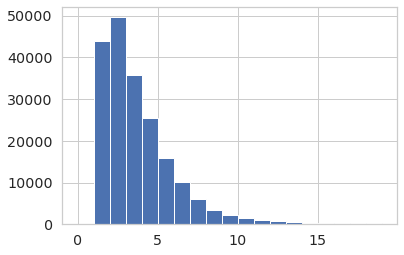

In [ ]:
df.order_packages.hist(bins=range(20))

In [ ]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
sol_line_amount,35025,17.4
order_packages,2310,1.1
STORE,2197,1.1


# armamos Dataset de trabajo

Agrupamos ventas por día_de_venta, tienda y producto y sumarizamos cantidad vendida (sol_ordered_qty) , valor total de la venta (sol_line_amount) y demora total de las ventas del día (dif_order_deliver)

In [ ]:
df_small = df.dropna()

In [ ]:
df_small.shape

(163122, 10)

In [ ]:
df_small = df_small.groupby(['so_order_date', 'STORE', 'reorder_buyer'])['sol_ordered_qty', 'sol_line_amount'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df_small.head()

sol_ordered_qty  sol_line_amount
so_order_date STORE         reorder_buyer                                  
2018-01-01    BC Auburn     7                         <NA>              NaN
                            22                        <NA>              NaN
                            27                        <NA>              NaN
                            39                        <NA>              NaN
              JL Alexandria 7                         <NA>              NaN

In [ ]:
df_small.tail()

sol_ordered_qty  sol_line_amount
so_order_date STORE              reorder_buyer                                  
2020-12-31    SG Website         39                        <NA>              NaN
              The Sleeping Giant 7                         <NA>              NaN
                                 22                           5          1666.56
                                 27                           3           808.66
                                 39                        <NA>              NaN

Eliminamos nulos

In [ ]:
df_small = df_small.dropna()

In [ ]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51728 entries, (Timestamp('2018-01-01 00:00:00'), 'JL Bundall', 7) to (Timestamp('2020-12-31 00:00:00'), 'The Sleeping Giant', 27)
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sol_ordered_qty  51728 non-null  Int64  
 1   sol_line_amount  51728 non-null  float64
dtypes: Int64(1), float64(1)
memory usage: 1.1 MB


In [ ]:
df_small.head()

sol_ordered_qty  sol_line_amount
so_order_date STORE             reorder_buyer                                  
2018-01-01    JL Bundall        7                            1             80.0
                                27                           3            948.0
              SG & JL Toowoomba 7                            1             76.0
                                27                           1            249.0
2018-01-02    JL Alexandria     7                            9            610.0

In [ ]:
# guardar df y df_small
#df.to_csv('productsol.csv')
#df_small.to_csv('productsolsummary.csv')

# Primer Modelo: Regresion Logística

In [ ]:
df_raw = df_small

In [ ]:
#df_small = df_raw

In [ ]:
df_small = df_small.reset_index([ 'STORE' , 'reorder_buyer' ])

In [ ]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51728 entries, 2018-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   STORE            51728 non-null  category
 1   reorder_buyer    51728 non-null  category
 2   sol_ordered_qty  51728 non-null  Int64   
 3   sol_line_amount  51728 non-null  float64 
dtypes: Int64(1), category(2), float64(1)
memory usage: 1.3 MB


In [ ]:
df_small["STORE_code"] = df_small["STORE"].cat.codes

In [ ]:
df_small.drop(columns='STORE', inplace=True)

In [ ]:
df_small.head()

,reorder_buyer,sol_ordered_qty,sol_line_amount,STORE_code
so_order_date,,,,
2018-01-01,7,1,80.0,4
2018-01-01,27,3,948.0,4
2018-01-01,7,1,76.0,35
2018-01-01,27,1,249.0,35
2018-01-02,7,9,610.0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59af329750>,
      dtype=object)

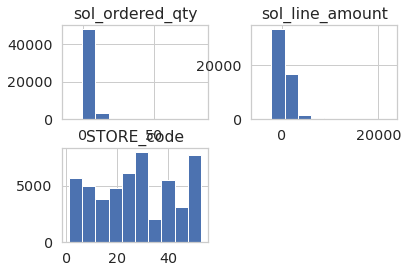

In [ ]:
df_small.hist()

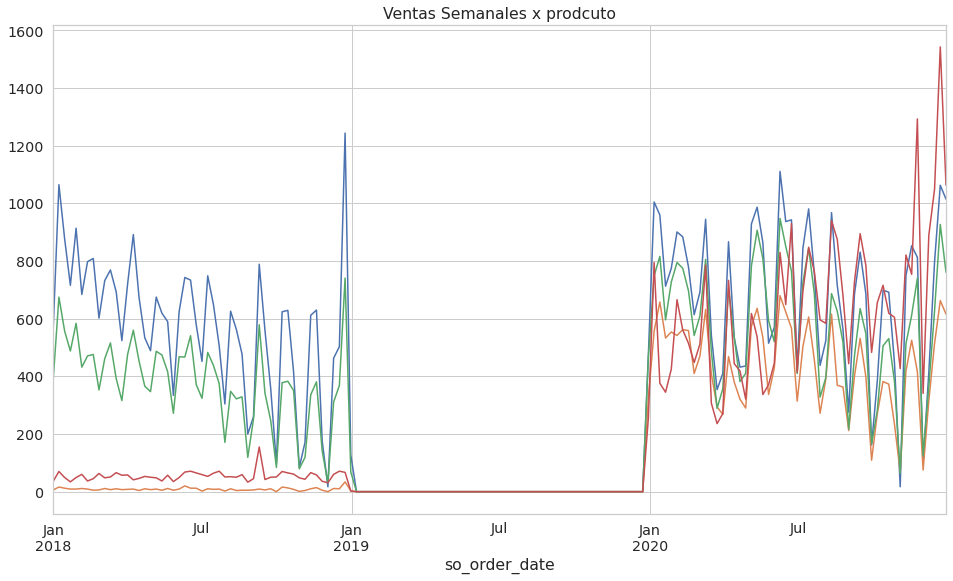

In [ ]:
items = pd.DataFrame(df_small.groupby(['so_order_date','reorder_buyer']).sum()['sol_ordered_qty']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)
items.plot(figsize=(16,9), title='Ventas Semanales x prodcuto', legend=None)
plt.show()

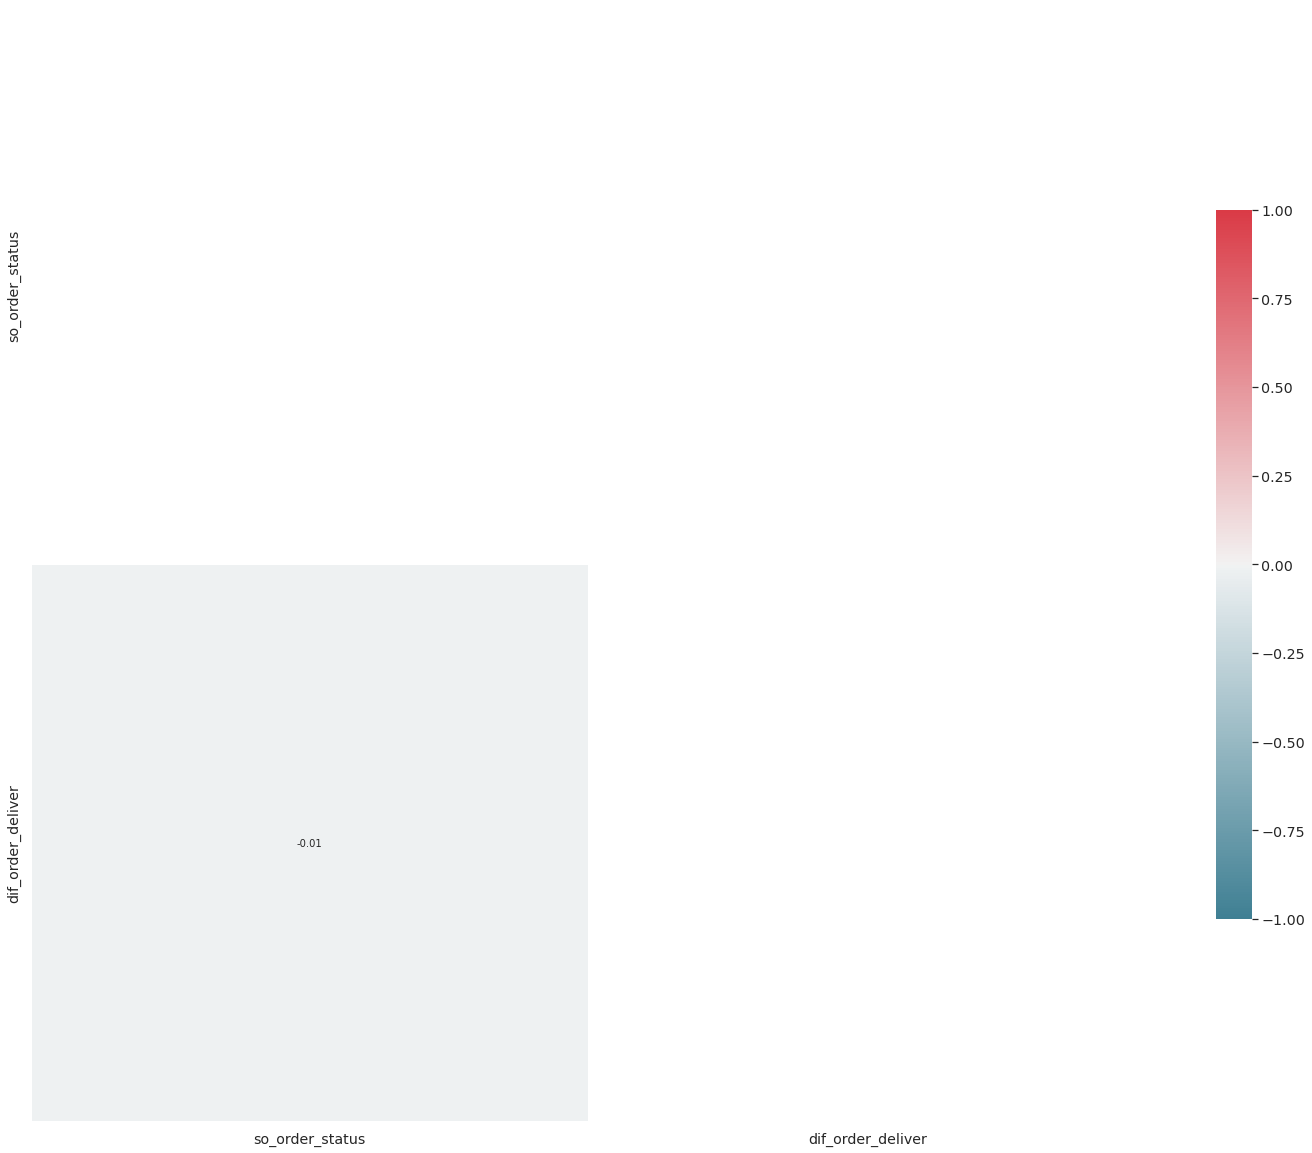

In [ ]:
# Generate and visualize the correlation matrix
corr = df.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

Nos faltan datos del año 2019

Vamos a predecir qué tienda lo vendió

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
df_small.reset_index(drop=True, inplace=True)


In [ ]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51728 entries, 0 to 51727
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   reorder_buyer    51728 non-null  category
 1   sol_ordered_qty  51728 non-null  Int64   
 2   sol_line_amount  51728 non-null  float64 
 3   STORE_code       51728 non-null  int8    
dtypes: Int64(1), category(1), float64(1), int8(1)
memory usage: 960.1 KB


En la línea anterior al quitar en indice de fecha, quedan repetidas observaciones de producto-store. Deberían recomputarse!

In [ ]:
x = df_small
y = df_small['reorder_buyer']

In [ ]:
#%% Dividir Training y Testing
porc_test= 0.1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= porc_test)
print("%d datos para training" %x_train.shape[0])
print("%d datos para testing" %x_test.shape[0])


46555 datos para training
5173 datos para testing


In [ ]:
y_test

50814    22
19519    27
45344     7
3949      7
12363    39
         ..
18407    22
20537    22
43513     7
23773    39
22300     7
Name: reorder_buyer, Length: 5173, dtype: category
Categories (4, int64): [7, 22, 27, 39]

In [ ]:
# Run the model and report the results
modelo = LogisticRegression(solver='saga', tol=0.1) # Saga es más rápido para dataset muy grandes
modelo.fit(x_train, y_train)

LogisticRegression(solver='saga', tol=0.1)

In [ ]:
y_pred_train = modelo.predict(x_train)
print("\nTrain   Accuracy: %.2f" % accuracy_score(y_train, y_pred_train ));
y_pred= modelo.predict(x_test)
print("\nTest   Accuracy: %.2f" % accuracy_score(y_test, y_pred ));
print(classification_report(y_test, y_pred));



Train   Accuracy: 0.56

Test   Accuracy: 0.56
              precision    recall  f1-score   support

           7       0.86      0.50      0.64      1870
          22       0.00      0.00      0.00       855
          27       0.38      0.92      0.54      1415
          39       0.92      0.63      0.75      1033

    accuracy                           0.56      5173
   macro avg       0.54      0.51      0.48      5173
weighted avg       0.60      0.56      0.53      5173



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_small.columns

Index(['reorder_buyer', 'sol_ordered_qty', 'sol_line_amount', 'STORE_code'], dtype='object')

# Segundo Modelo: Regresion lineal

La regresion lineal la vamos a implementar para predecir la demora. Este modelo nos va a permitir explorar los coeficientes para ver la interacción de variables. El caso de uso sería determinar para un tipo de producto cual es la demora proyectada.

In [ ]:
df_small_2 = df.dropna()

In [ ]:
df_small_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163122 entries, 90285 to 224174
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   reorder_buyer      163122 non-null  category      
 1   STORE              163122 non-null  category      
 2   so_order_date      163122 non-null  datetime64[ns]
 3   so_delivery_date   163122 non-null  datetime64[ns]
 4   order_packages     163122 non-null  Int64         
 5   so_order_status    163122 non-null  category      
 6   so_invoice_no      163122 non-null  category      
 7   sol_ordered_qty    163122 non-null  Int64         
 8   sol_line_amount    163122 non-null  float64       
 9   dif_order_deliver  163122 non-null  float64       
dtypes: Int64(2), category(4), datetime64[ns](2), float64(2)
memory usage: 15.9 MB


In [ ]:
# df_small_2 = df_small_2.reset_index([ 'STORE' , 'reorder_buyer' ])

In [ ]:
# extraer mes de venta
# df_small_2['month'] = df_small_2.index.month
df_small_2['month'] = df_small_2['so_order_date'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_small_2.head()

,reorder_buyer,STORE,so_order_date,so_delivery_date,order_packages,so_order_status,so_invoice_no,sol_ordered_qty,sol_line_amount,dif_order_deliver,month
90285,22,SG Auburn,2018-01-14,2018-01-31,2,90,547052,1,313.0,17.0,1
90286,22,SG & JL Hornsby,2018-01-18,2018-05-03,1,90,548130,1,329.0,105.0,1
90288,22,SG Auburn,2018-04-02,2018-06-02,4,90,553410,1,310.0,61.0,4
90289,22,SG & JL Penrith,2018-06-02,2018-10-02,1,90,553979,1,329.0,122.0,6
90290,22,SG & JL Penrith,2018-02-17,2018-02-21,3,90,556930,1,305.0,4.0,2


In [ ]:
df_small_2["STORE_code"] = df_small_2["STORE"].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_small_2.drop(columns='STORE', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_small_2.head()

,reorder_buyer,so_order_date,so_delivery_date,order_packages,so_order_status,so_invoice_no,sol_ordered_qty,sol_line_amount,dif_order_deliver,month,STORE_code
90285,22,2018-01-14,2018-01-31,2,90,547052,1,313.0,17.0,1,40
90286,22,2018-01-18,2018-05-03,1,90,548130,1,329.0,105.0,1,25
90288,22,2018-04-02,2018-06-02,4,90,553410,1,310.0,61.0,4,40
90289,22,2018-06-02,2018-10-02,1,90,553979,1,329.0,122.0,6,29
90290,22,2018-02-17,2018-02-21,3,90,556930,1,305.0,4.0,2,29


In [ ]:
df_small_2 = df_small_2[df_small_2.reorder_buyer == 7] # filtro producto 7

In [ ]:
df_small_2.head()

,reorder_buyer,so_order_date,so_delivery_date,order_packages,so_order_status,so_invoice_no,sol_ordered_qty,sol_line_amount,dif_order_deliver,month,STORE_code
121365,7,2018-03-29,2018-08-16,1,90,568017,1,50.0,140.0,3,1
121367,7,2018-04-04,2018-10-04,2,90,569377,1,50.0,183.0,4,28
121368,7,2018-04-14,2018-05-25,27,90,572121,1,300.0,41.0,4,1
121372,7,2018-04-28,2018-05-05,1,90,576093,1,50.0,7.0,4,40
121374,7,2018-02-05,2018-09-05,3,90,577451,1,50.0,212.0,2,43


In [ ]:
df_small_2.shape

(66690, 11)

In [ ]:
df_small_2 = df_small_2.groupby(['so_order_date', 'STORE_code'])['sol_ordered_qty', 'sol_line_amount', 'dif_order_deliver'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df_small_2.head()

sol_ordered_qty  sol_line_amount  dif_order_deliver
so_order_date STORE_code                                                     
2018-01-01    4                         1             80.0              123.0
              35                        1             76.0               26.0
2018-01-02    1                         9            610.0             2215.0
              2                         5            315.0              661.0
              4                         2            160.0              259.0

In [ ]:
df_small_2 = df_small_2.reset_index([ 'STORE_code'])

In [ ]:
df_small_2['month'] = df_small_2.index.month

In [ ]:
df_small_2.head()

,STORE_code,sol_ordered_qty,sol_line_amount,dif_order_deliver,month
so_order_date,,,,,
2018-01-01,4,1,80.0,123.0,1
2018-01-01,35,1,76.0,26.0,1
2018-01-02,1,9,610.0,2215.0,1
2018-01-02,2,5,315.0,661.0,1
2018-01-02,4,2,160.0,259.0,1


In [ ]:
df_small_2_0 = df_small_2.reset_index(drop=True)

In [ ]:
df_small_2_0.head()

,STORE_code,sol_ordered_qty,sol_line_amount,dif_order_deliver,month
0,4,1,80.0,123.0,1
1,35,1,76.0,26.0,1
2,1,9,610.0,2215.0,1
3,2,5,315.0,661.0,1
4,4,2,160.0,259.0,1


Muy importante dividir demora por cantidad de productos entregados

In [ ]:
#df_small_2_0['mean_dif'] = round(df_small_2_0['dif_order_deliver'] / df_small_2_0['sol_ordered_qty'])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
data = df_small_2_0

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
#oe_style = OneHotEncoder()
#oe_results = oe_style.fit_transform(data[["month"]])
#pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()
# data = data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))
#data = pd.get_dummies(data, columns=["month"]).head()


El dataset tiene 18892 registros, de 4 dimensiones


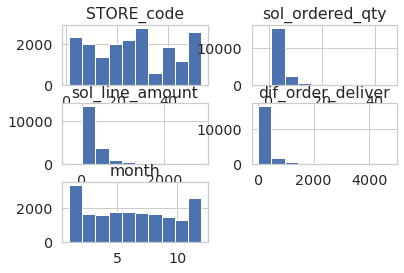

In [ ]:
x = data.drop('dif_order_deliver', axis=1)
y = data['dif_order_deliver']
n,d = x.shape
print("El dataset tiene %d registros, de %d dimensiones" %(n, d))

# visualizar distribución de los features
data.hist();

In [ ]:
x.head()

,STORE_code,sol_ordered_qty,sol_line_amount,month
0,4,1,80.0,1
1,35,1,76.0,1
2,1,9,610.0,1
3,2,5,315.0,1
4,4,2,160.0,1


In [ ]:
#%% Normalizar los datos
NORMALIZAR = 1
if (NORMALIZAR):
    scaler = StandardScaler()  
    scaler.fit(x)  
    x = scaler.transform(x)    


In [ ]:
x

array([[-1.43218663, -0.73843752, -0.77968279, -1.54768127],
       [ 0.57679759, -0.73843752, -0.79570825, -1.54768127],
       [-1.62660446,  1.61504497,  1.34369091, -1.54768127],
       ...,
       [ 1.54888673, -0.44425221, -0.45917355,  1.72118215],
       [ 1.61369267,  0.43830372,  0.42222685,  1.72118215],
       [ 1.67849861,  1.90923028,  1.86451842,  1.72118215]])

In [ ]:
#%% Entrenar modelo de Regresión Lineal
# crea el objeto modelo
modelo= LinearRegression()

#%% entrena
modelo.fit(x, y)
# predice
y_predict= modelo.predict(x)
#coeficientes (parámetros del modelo)
w= modelo.coef_
b= modelo.intercept_

# scores
mse_error= mean_squared_error(y_predict, y)
print("Error cuad. medio: %.2f" % mse_error)
mae_error= mean_absolute_error(y_predict, y)
print("Error abs. medio: %.2f" % mae_error)
r2_score= r2_score(y, y_predict)
print("r2_score: %.2f" % r2_score)

Error cuad. medio: 82369.33
Error abs. medio: 177.98
r2_score: 0.38


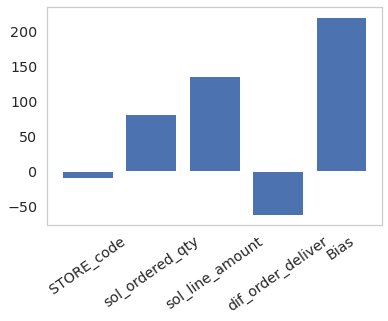

In [ ]:
#%% plot coeficientes
plt.figure()
plt.bar(range(d+1), np.concatenate((w,[b])))
labels= data.columns.values; labels[-1]= 'Bias'
plt.xticks(range(w.shape[0]+1), labels, rotation=35)
plt.grid()


(Text(0.5, 0, 'valores reales'), Text(0, 0.5, 'Valores predichos'))

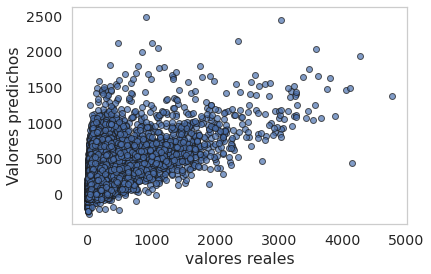

In [ ]:
#%% Plot valores esperados vs valores predichos
plt.figure()
plt.scatter(y, y_predict,alpha=0.7, edgecolor='k'), plt.grid()
plt.xlabel("valores reales"), plt.ylabel("Valores predichos")

Consideraciones Finales
- Máxima prioridad: definiciones y certeza en el significado de los features.
- Para armar el data set necesitamos una buena cantidad de observaciones no nulas de las siguientes columnas: 'reorder_buyer' (en realidad: producto = 'stk_description', ej 38 = sofa_dalas), 'sol_ordered_qty', 'sol_line_amount'(monto en dolares de la venta por unidad), 'STORE', 'so_delivery_date',..
- Podemos integrar nuevos features, ej: ventas minoristas por mes, promedio de ventas, 
- Podrìamos jugar con one-hot para los categòricos.
- La variable target: demora, tiene que ser exacta y limpia. La demora tiene que calcularse por venta. La demora en un día tiene que calcularse demora * 1/n. Si pudiermos tener muchas observaciones y más fueatures podríamos intenter hacer una RL binaria

CASO_DE_USO: *Si tengo demoras como afecta las ventas? Si hay demora cuanto baja la venta? Precios y variación precios. Disponibilidad de stock y precios.*

# Tercer Modelo y Cambio del Dataset

## Paquetes y herramientas de análisis

In [1]:
# data wrangling
import pandas as pd
import numpy as np
import os
import nltk

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# machine learning
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

# others
import bs4
import io
import requests
from google.colab import drive
import json

# initialize some package settings
sns.set(style="whitegrid", color_codes=True, font_scale=1.3)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [3]:
%cd  'drive/My Drive/Colab Notebooks/data'

/content/drive/My Drive/Colab Notebooks/data


In [4]:
%ls

corpus_fallosmetdat.json  productsol.csv         tbdoctrina.json
corpus_textosfallos.json  productsolsummary.csv  tbfallos.json
Libro1.csv                sales2018-2021.csv     tbmetdat.json


## Preparando el Dataset de análisis

In [5]:
#sales = pd.read_csv("sales2018-2021.csv", sep= ";", header=0, encoding='latin1',  dayfirst=True)
sales = pd.read_csv("sales2018-2021.csv", sep= ";", header=0, encoding='latin1', skip_blank_lines=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,11,13,14,15,17,18,24,25,28,29,32,33,34,35,36,41,42,45,46,48,53,54,56,57,60,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859382 entries, 0 to 859381
Data columns (total 71 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   db_source         859382 non-null  int64  
 1   so_order_no       859382 non-null  object 
 2   so_bo_suffix      785576 non-null  object 
 3   so_cust_code      859382 non-null  object 
 4   so_order_date     859382 non-null  object 
 5   so_delivery_date  859382 non-null  object 
 6   MTH               859382 non-null  int64  
 7   WEEK              859382 non-null  int64  
 8   WEEKDAY           859382 non-null  int64  
 9   DAY               859382 non-null  object 
 10  FISCAL YEAR       859382 non-null  object 
 11  YEAR              859382 non-null  object 
 12  delivery_date     859382 non-null  object 
 13  order_packages    859382 non-null  object 
 14  so_order_weight   859382 non-null  object 
 15  job_code          777875 non-null  object 
 16  so_order_status   85

In [ ]:
sales.head()

,db_source,so_order_no,so_bo_suffix,so_cust_code,so_order_date,so_delivery_date,MTH,WEEK,WEEKDAY,DAY,FISCAL YEAR,YEAR,delivery_date,order_packages,so_order_weight,job_code,so_order_status,reason_code,order_type_code,so_whse_code,territory_code,STORE,so_cust_type,so_rep_code,tax_exemption_no,so_terms_disc,so_price_code,cust_reference,so_invoice_no,credit_note_no,so_invoice_date,processing_date,total_amount,total_tax_adj,shipped_tax_adj,total_charges,so_curr_code,so_user_id_code,so_order_source,spare_alpha2_2,tax_calc_level,so_store_id,so_terminal,so_operator_code,pos_process,so_dif_flag,so_document_no,so_bo_suffix2,sol_line_seq,reorder_buyer,stk_description,stk_desc_line_2,stk_desc_line_3,sol_ordered_qty,sol_line_amount,stk_description3,stock_code,stock_code4,sys_description,stk_stock_status,stock_group,Status,Sales no GST,Month Proc,rep,STATE,Year proc,returns,Month proc2,Reord_buy_Cat,Subcategory
0,1,1118301,NaN,487123,24/11/2021,3/12/2021,11,22,3,miércoles,2021-2022,2021,3/12/2021,2,62,NaN,30,NaN,NaN,1223,223,SG & JL Penrith Clearance,R,118,NaN,NaN,R0,NaN,1118301,0,1/12/2021,1/12/2021,394,0,0,0,NaN,pos1223,3,M,L,1223,1,118,24/11/2021 04:43,NaN,1118301,NaN,1,32,JL Aston,TV Unit 2 Dwr Teak,1600L x 420D x 550H,1,299,JL Aston,105AST160TVUTEA,105AST160TVUTEA,JL House Furniture,S,5023,Ready for Picking,271.818182,12,Leslie Jackson,NSW,2021,sale,12,Dinning/living Furniture,0
1,1,1026640,NaN,459298,2/6/2021,10/12/2021,6,49,3,miércoles,2020-2021,2021,0/1/1900,8,141,NaN,30,NaN,NaN,5300,514,JL Northlakes,R,26,NaN,NaN,R0,CDB,1026640,0,2/6/2021,2/6/2021,3271.45,0,0,0,NaN,pos5214,3,M,L,5214,1,26,2/6/2021 06:43,NaN,1026640,NaN,23,27,JL Aston,Bedside Teak,2Dwr,1,179.62,JL Aston,105AST2DRBSTTEA,105AST2DRBSTTEA,SG Bedroom Furniture,S,4012,Ready for Picking,163.290909,6,Lauren Petroff,QLD,2021,sale,6,Others,0
2,1,1075156,NaN,SGW106054,25/8/2021,8/10/2021,8,9,3,miércoles,2021-2022,2021,0/1/1900,5,0,NaN,30,NaN,NaN,2399,200,SG & JL NSW Warehouse,R,999,NaN,NaN,R0,1068077,NaN,0,0/1/1900,0/1/1900,0,0,0,0,NaN,dallas,S,M,L,NaN,0,NaN,1/1/1900 00:00,NaN,1075156,NaN,3,27,JL Aston,Bedside Teak,2Dwr,2,0,JL Aston,105AST2DRBSTTEA,105AST2DRBSTTEA,SG Bedroom Furniture,S,4012,Ready for Picking,0.000000,1,SG-JL-Office,NSW,1900,sale,1,Others,0
3,1,1083345,NaN,475950,22/9/2021,29/9/2021,9,13,3,miércoles,2021-2022,2021,0/1/1900,5,0,NaN,30,NaN,NaN,5300,516,SG Aspley,R,129,NaN,NaN,R0,LINKED 1083268,1083345,0,22/9/2021,22/9/2021,1578.99,0,0,0,NaN,pos5216,3,M,L,5216,1,129,22/9/2021 05:24,NaN,1083345,NaN,3,27,JL Aston,Bedside Teak,2Dwr,2,414.58,JL Aston,105AST2DRBSTTEA,105AST2DRBSTTEA,SG Bedroom Furniture,S,4012,Ready for Picking,376.890909,9,Dallas Young,QLD,2021,sale,9,Others,0
4,1,1095572,NaN,479513,20/10/2021,17/1/2022,10,17,3,miércoles,2021-2022,2021,0/1/1900,0,0,NaN,11,NaN,NaN,2200,252,SG Kotara,R,123,NaN,NaN,R0,20/10 ON B/O,1095572,0,20/10/2021,20/10/2021,389.3,0,0,0,NaN,pos1252,3,M,L,1252,1,123,20/10/2021 02:04,NaN,1095572,NaN,1,27,JL Aston,Bedside Teak,2Dwr,1,229,JL Aston,105AST2DRBSTTEA,105AST2DRBSTTEA,SG Bedroom Furniture,S,4012,Backorder,208.181818,10,Megan Thompson,NSW,2021,sale,10,Others,0


In [ ]:
sales.so_order_date.value_counts()

28/11/2021    3191
27/11/2021    2636
29/11/2021    2005
26/12/2020    1966
26/11/2021    1849
              ... 
25/12/2020      15
10/4/2020       15
12/4/2020        8
19/4/2019        2
30/3/2018        1
Name: so_order_date, Length: 1428, dtype: int64

In [ ]:
sales.describe()

,db_source,MTH,WEEK,WEEKDAY,so_order_status,so_whse_code,territory_code,reorder_buyer,Sales no GST,Month Proc,Year proc,Month proc2
count,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000,859382.000000
mean,1.974072,6.518562,26.996404,4.481395,88.313405,2993.277037,337.678350,24.002119,281.053884,6.531208,2018.583767,6.531208
std,0.158920,3.437880,15.131469,2.084268,10.785615,1513.464698,137.498003,13.614904,444.481323,3.474427,11.359970,3.474427
min,1.000000,1.000000,0.000000,1.000000,11.000000,54.000000,100.000000,5.000000,-25538.154550,1.000000,1900.000000,1.000000
25%,2.000000,4.000000,15.000000,3.000000,90.000000,2200.000000,209.000000,7.000000,36.363636,3.000000,2019.000000,3.000000
50%,2.000000,6.000000,27.000000,5.000000,90.000000,2200.000000,247.000000,27.000000,144.545455,7.000000,2020.000000,7.000000
75%,2.000000,10.000000,40.000000,6.000000,90.000000,5207.000000,504.000000,36.000000,430.954545,10.000000,2021.000000,10.000000
max,2.000000,12.000000,53.000000,7.000000,90.000000,6202.000000,602.000000,99.000000,36543.572730,12.000000,2021.000000,12.000000


In [6]:
sales["so_order_date"] = pd.to_datetime(sales["so_order_date"], format='%d/%m/%Y') # Sin problemas en el formateo
sales["so_delivery_date"] = pd.to_datetime(sales["so_delivery_date"], format='%d/%m/%Y', errors='coerce') # tiene anomalías
#sales["so_delivery_date"] = pd.to_datetime(sales["so_delivery_date"], format='%d/%m/%Y') # tiene anomalías


In [ ]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [ ]:
missing_values_table(sales)

Your selected dataframe has 71 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
job_code,81507,9.5
tax_exemption_no,81507,9.5
so_dif_flag,81507,9.5
so_curr_code,81505,9.5
order_type_code,81490,9.5
so_terms_disc,81374,9.5
reason_code,79854,9.3
so_bo_suffix,73806,8.6
so_bo_suffix2,73806,8.6
cust_reference,61694,7.2


La cantidad de datos anómalos en so_delivery_date, es la misma que tenía en el data set de los años2018-2020, pero como hay mas datos el porcentaje bajó.

### Limpiamos variable Tempora 

In [7]:
sales_clean = sales.dropna(subset=['so_order_date'])
sales_clean = sales.dropna(subset=['so_delivery_date'])

In [ ]:
sales_clean['so_order_date'].value_counts()

2021-11-28    3185
2021-11-27    2626
2021-11-29    1994
2020-12-26    1966
2021-11-26    1843
              ... 
2020-04-10      15
2020-12-25      15
2020-04-12       8
2019-04-19       2
2018-03-30       1
Name: so_order_date, Length: 1428, dtype: int64

In [ ]:
missing_values_table(sales_clean)

Your selected dataframe has 71 columns.
There are 22 columns that have missing values.


,Missing Values,% of Total Values
so_dif_flag,80892,9.5
tax_exemption_no,80892,9.5
job_code,80892,9.5
so_curr_code,80890,9.5
order_type_code,80875,9.5
so_terms_disc,80759,9.5
reason_code,79842,9.4
so_bo_suffix,73191,8.6
so_bo_suffix2,73191,8.6
cust_reference,61226,7.2


Exploremos un poco la series de tiempo asociados a ventas.

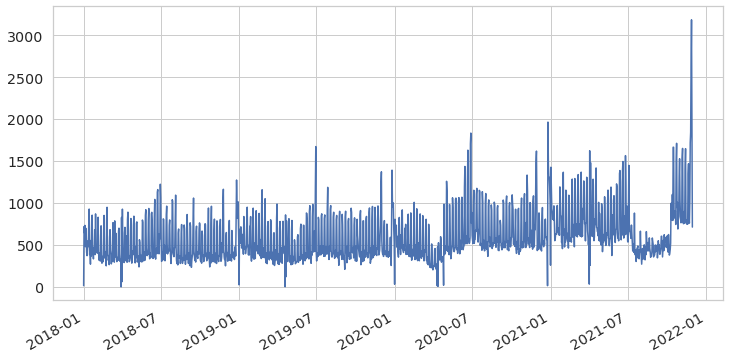

In [ ]:
ts = sales_clean['so_order_date'].value_counts().sort_index()
fig1, ax1 = plt.subplots(figsize=(12,6))
ts.plot()

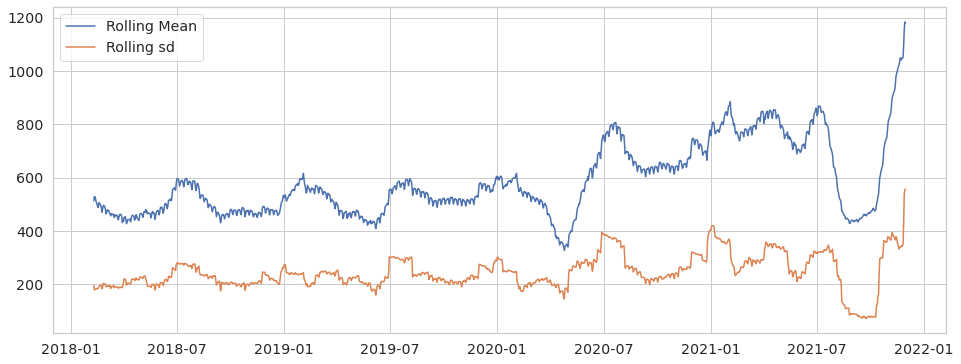

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=40,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=40,center=False).std(),label='Rolling sd');
plt.legend();

Advertencia: si en vez de limpiar del dataset de valores nulos en la columna 'so_order_date' se eliminan los valores nulos de todas las columnas se pierden muhco más observaciones, sobretodo del último período y la serie temporal se distorsiona bastante. Veamos

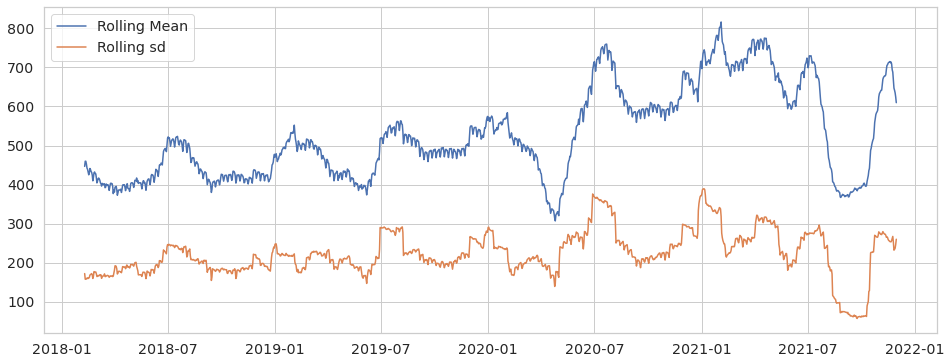

In [ ]:
sales_fullclean = sales.dropna()
ts2 = sales_fullclean['so_order_date'].value_counts().sort_index()
plt.figure(figsize=(16,6))
plt.plot(ts2.rolling(window=40,center=False).mean(),label='Rolling Mean');
plt.plot(ts2.rolling(window=40,center=False).std(),label='Rolling sd');
plt.legend();


Sigamos trabajando con el dataset parcialmente limpio en la columna 'so_order_date', pero asumiendo que el modelo a entrenar no va a tener datos importante. 

Vamos a ver estacionalidad y tendencia

<Figure size 1440x1152 with 0 Axes>

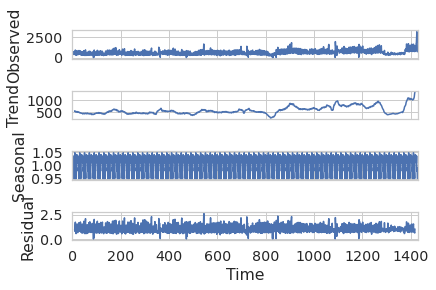

In [ ]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=20,model="multiplicative")
plt.figure(figsize=(20,16))
fig = res.plot()

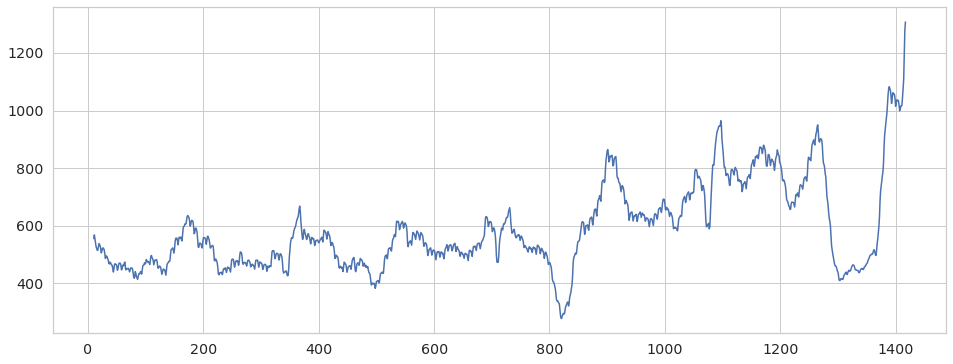

In [ ]:
trend = res.trend
plt.figure(figsize=(16,6))
plt.plot(trend)

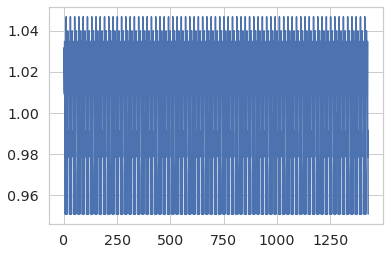

In [ ]:
seasonal = res.seasonal
plt.plot(seasonal)

In [ ]:
# Additive model
#res = sm.tsa.seasonal_decompose(ts.values,freq=20,model="additive")
#plt.figure(figsize=(16,12))
#fig = res.plot()
#fig.show()

Vamos a ver ahora nueva variable que identifica el producto: 'stk_description'

In [ ]:
sales_clean['stk_description'].value_counts()

 Delivery -                     155081
 A&S Silver (3 Zone Pocket)      25345
 SERVICE -                       20402
 A&S Gold +                      20112
 Customer Declined               16790
                                 ...  
JL Fraser                            1
Albi Hanging Pearls                  1
A&S Soft Pillow                      1
 SG Fraser                           1
Albi Milla                           1
Name: stk_description, Length: 1406, dtype: int64

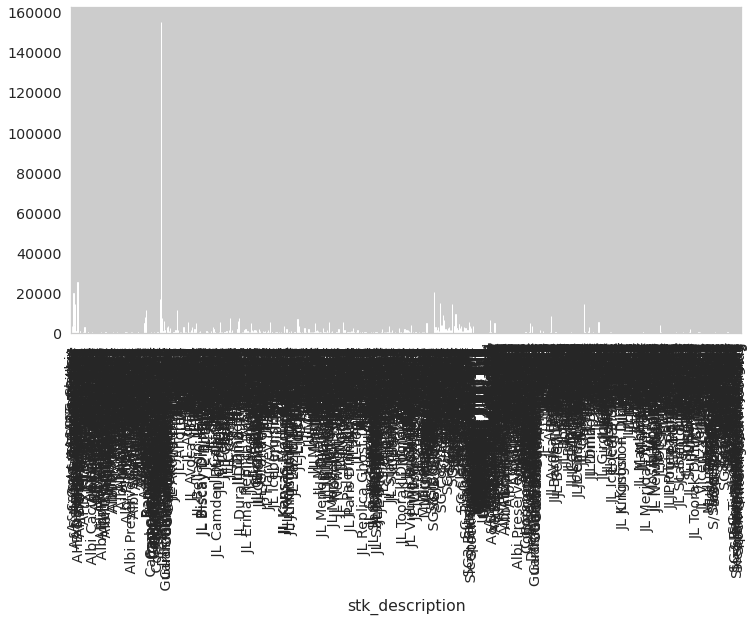

In [ ]:
products = sales_clean.groupby(["stk_description"]).size()
fig1, ax1 = plt.subplots(figsize=(12,6))
products.plot.bar()

Veamos entonces la variable para grupos de productos 'reorder_buyer' 

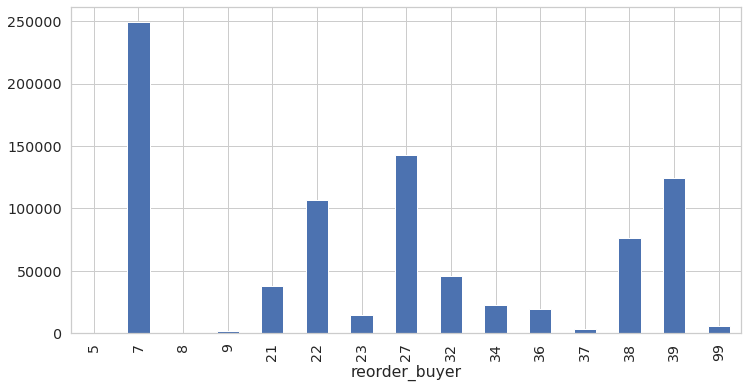

In [ ]:
reorder_buyer = sales_clean.groupby(["reorder_buyer"]).size()
fig1, ax1 = plt.subplots(figsize=(12,6))
reorder_buyer.plot.bar()

## Formateamos y creamos nuevos features

IMPORTANTE: creamos Variable demora

In [8]:
sales_clean['dif_order_deliver'] = (sales_clean['so_delivery_date'] - sales_clean['so_order_date']).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
cols = ['reorder_buyer', 'STORE', 'so_order_status', 'so_invoice_no', 'territory_code']
sales_clean[cols] = sales_clean[cols].astype('category')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
sales_clean['order_packages'] = pd.to_numeric(sales_clean['order_packages'], errors='coerce').convert_dtypes()
sales_clean['sol_ordered_qty'] = pd.to_numeric(sales_clean['sol_ordered_qty'], errors='coerce').convert_dtypes()
sales_clean['sol_line_amount'] = pd.to_numeric(sales_clean['sol_line_amount'], errors='coerce').convert_dtypes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

### Abrimos punto respaldo del Dataset de trabajo

In [11]:
df_small_2 = sales_clean

In [12]:
df_small_2.shape

(850016, 72)

In [13]:
df_small_2["STORE_code"] = df_small_2["STORE"].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
df_small_2.drop(columns='STORE', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#df_small_2 = df.df_small_2.dropna()

## Creamos nuestra tabla resumen con estadísticos

In [15]:
# Ram insuficiente para computar:
df_small_2 = df_small_2.groupby(['so_order_date', 'STORE_code', 'reorder_buyer' ])['sol_ordered_qty', 'sol_line_amount', 'dif_order_deliver'].sum()
# df_small_2 = df_small_2.groupby(['so_order_date', 'reorder_buyer' ])['sol_ordered_qty', 'sol_line_amount', 'dif_order_deliver'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [ ]:
df_small_2.head(100)

sol_ordered_qty  ...  dif_order_deliver
so_order_date STORE_code reorder_buyer                   ...                   
2018-01-01    -1         5                         <NA>  ...                NaN
                         7                         <NA>  ...                NaN
                         8                         <NA>  ...                NaN
                         9                         <NA>  ...                NaN
                         21                        <NA>  ...                NaN
...                                                 ...  ...                ...
               5         22                        <NA>  ...                NaN
                         23                        <NA>  ...                NaN
                         27                           3  ...              188.0
                         32                        <NA>  ...                NaN
                         34                        <NA>  ...                NaN

[100 rows x 3 columns]

## Limpiamos tabla von valores nulos

In [16]:
df_small_2 = df_small_2.dropna()

In [17]:
df_small_2.head(20)

sol_ordered_qty  ...  dif_order_deliver
so_order_date STORE_code reorder_buyer                   ...                   
2018-01-01     5         7                            2  ...              188.0
                         27                           3  ...              188.0
               10        32                           1  ...               10.0
                         39                           1  ...                0.0
               39        7                            1  ...               26.0
                         21                           3  ...               31.0
                         22                           2  ...               31.0
                         27                           1  ...                0.0
                         32                           2  ...                0.0
                         39                           1  ...                0.0
2018-01-02    -1         7                            2  ...                8.0
                         22                           1  ...                4.0
                         32                           1  ...                0.0
                         36                           6  ...               18.0
                         39                           7  ...                0.0
               2         7                            7  ...              155.0
                         21                           3  ...              114.0
                         22                           4  ...                4.0
                         23                           3  ...              114.0
                         27                           3  ...              148.0

[20 rows x 3 columns]

In [ ]:
df_small_2.shape

(248224, 3)

creamos features: MTH	WEEK	WEEKDAY

In [18]:
df_small_2 = df_small_2.reset_index([ 'so_order_date'])
df_small_2 = df_small_2.reset_index([ 'reorder_buyer'])
df_small_2 = df_small_2.reset_index([ 'STORE_code'])

In [19]:
df_small_2.head()

,STORE_code,reorder_buyer,so_order_date,sol_ordered_qty,sol_line_amount,dif_order_deliver
0,5,7,2018-01-01,2,80.0,188.0
1,5,27,2018-01-01,3,948.0,188.0
2,10,32,2018-01-01,1,399.0,10.0
3,10,39,2018-01-01,1,295.0,0.0
4,39,7,2018-01-01,1,76.0,26.0


In [ ]:
df_small_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248224 entries, 0 to 248223
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   STORE_code         248224 non-null  int64         
 1   reorder_buyer      248224 non-null  category      
 2   so_order_date      248224 non-null  datetime64[ns]
 3   sol_ordered_qty    248224 non-null  Int64         
 4   sol_line_amount    248224 non-null  float64       
 5   dif_order_deliver  248224 non-null  float64       
dtypes: Int64(1), category(1), datetime64[ns](1), float64(2), int64(1)
memory usage: 9.9 MB


In [21]:
df_small_2['month'] = df_small_2['so_order_date'].dt.month

In [22]:
df_small_2['weekday'] =  df_small_2['so_order_date'].dt.weekday

In [23]:
df_small_2['week'] = df_small_2['so_order_date'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [25]:
df_small_2.describe()

,STORE_code,sol_ordered_qty,sol_line_amount,dif_order_deliver,month,weekday,week
count,248224.000000,248224.000000,248224.000000,248224.000000,248224.000000,248224.000000,248224.000000
mean,27.769611,3.842364,828.453327,54.198430,6.450255,3.232721,26.291882
std,16.960612,4.736389,1247.476286,105.200372,3.423204,2.052161,15.004839
min,-1.000000,-376.000000,-4917.000000,-3605.000000,1.000000,0.000000,1.000000
25%,13.000000,1.000000,160.000000,5.000000,3.000000,1.000000,13.000000
50%,28.000000,2.000000,448.000000,17.000000,6.000000,3.000000,26.000000
75%,41.000000,5.000000,998.000000,57.000000,9.000000,5.000000,40.000000
max,60.000000,220.000000,77864.800000,2654.000000,12.000000,6.000000,53.000000


quitamos valos negativos de las variables cuantitativas

In [26]:
df_small_2 = df_small_2[df_small_2['dif_order_deliver'] > 0] 
df_small_2 = df_small_2[df_small_2['sol_line_amount'] > 0] 
df_small_2 = df_small_2[df_small_2['sol_ordered_qty'] > 0] 

In [27]:
df_small_2.describe()

,STORE_code,sol_ordered_qty,sol_line_amount,dif_order_deliver,month,weekday,week
count,197203.000000,197203.000000,197203.000000,197203.000000,197203.000000,197203.000000,197203.000000
mean,28.285812,4.254738,1022.870563,62.616390,6.447280,3.286806,26.284975
std,17.330077,4.764634,1321.333238,110.811806,3.427997,2.066801,15.028545
min,-1.000000,1.000000,0.010000,1.000000,1.000000,0.000000,1.000000
25%,13.000000,1.000000,308.000000,8.000000,3.000000,1.000000,13.000000
50%,28.000000,3.000000,599.000000,23.000000,6.000000,3.000000,26.000000
75%,43.000000,5.000000,1239.000000,69.000000,10.000000,5.000000,40.000000
max,60.000000,220.000000,77864.800000,2654.000000,12.000000,6.000000,53.000000


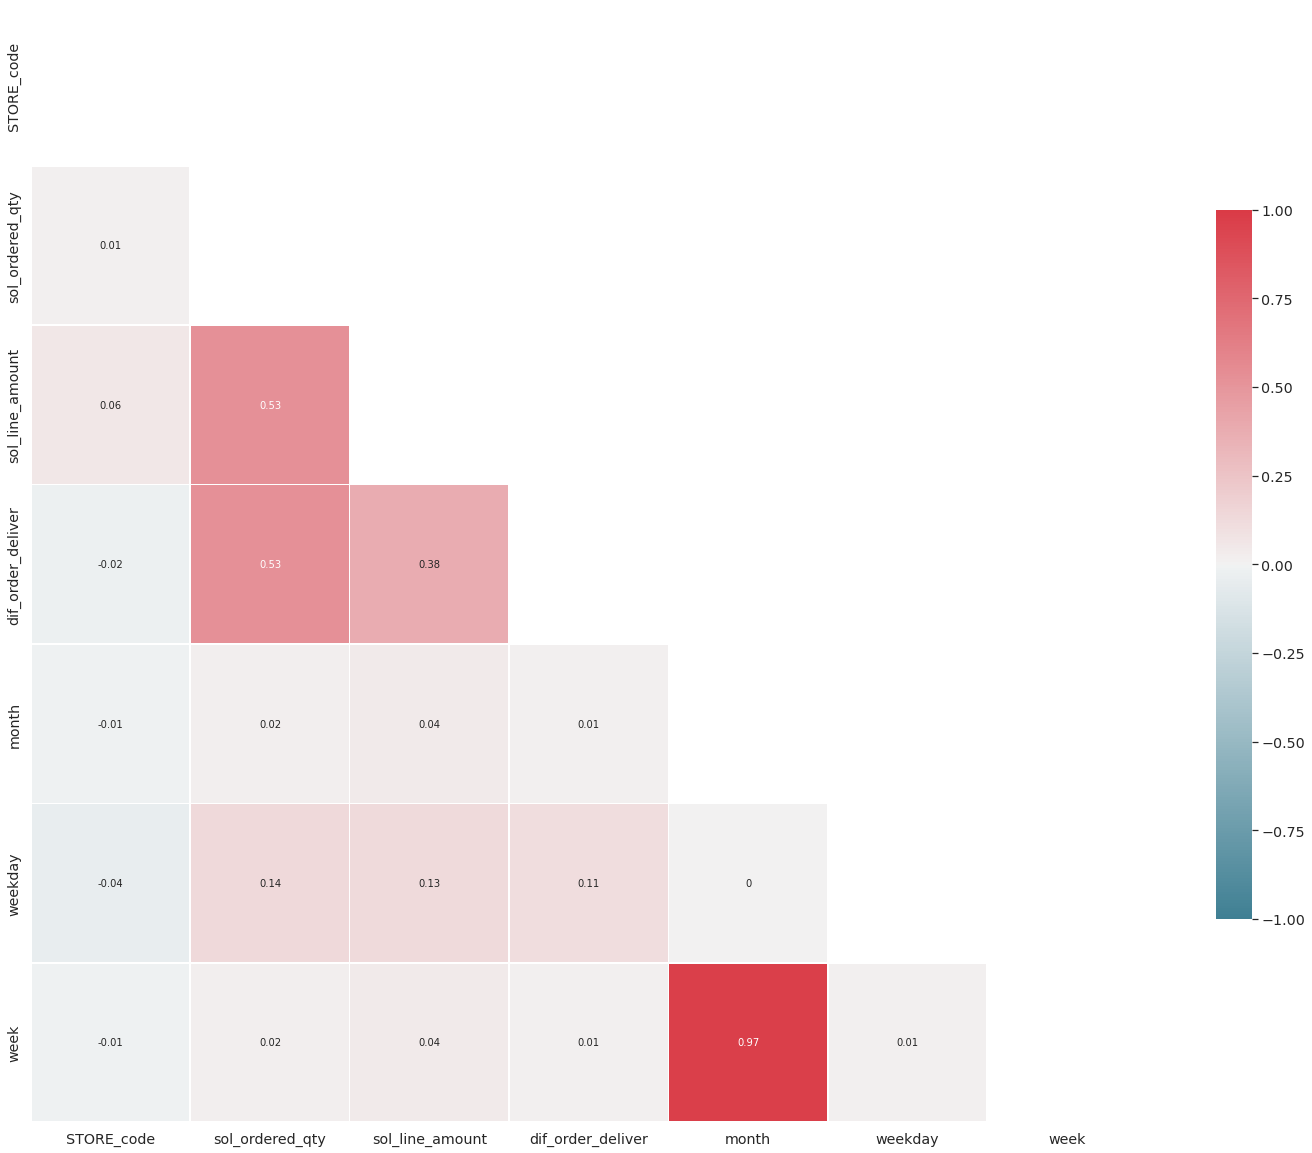

In [28]:
# Generate and visualize the correlation matrix
corr = df_small_2.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

## Iniciamos pasos para el entrenamiento

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

### Abrimos punto de respaldo de la tabla de estadísticos

In [122]:
data = df_small_2

In [123]:
data.shape

(197203, 9)

## Removemos outliers con z-score

In [124]:
from scipy import stats
dif = data['dif_order_deliver']
z_scores = stats.zscore(dif)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)

In [125]:
data = data[filtered_entries]

In [126]:
data.head()

,STORE_code,reorder_buyer,so_order_date,sol_ordered_qty,sol_line_amount,dif_order_deliver,month,weekday,week
0,5,7,2018-01-01,2,80.0,188.0,1,0,1
1,5,27,2018-01-01,3,948.0,188.0,1,0,1
2,10,32,2018-01-01,1,399.0,10.0,1,0,1
4,39,7,2018-01-01,1,76.0,26.0,1,0,1
5,39,21,2018-01-01,3,1138.0,31.0,1,0,1


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193057 entries, 0 to 248223
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   STORE_code         193057 non-null  int64         
 1   reorder_buyer      193057 non-null  category      
 2   so_order_date      193057 non-null  datetime64[ns]
 3   sol_ordered_qty    193057 non-null  Int64         
 4   sol_line_amount    193057 non-null  float64       
 5   dif_order_deliver  193057 non-null  float64       
 6   month              193057 non-null  int64         
 7   weekday            193057 non-null  int64         
 8   week               193057 non-null  int64         
dtypes: Int64(1), category(1), datetime64[ns](1), float64(2), int64(4)
memory usage: 13.6 MB


## Creamos on-hot de Store

Mantenemos todas las variables temporales (month, weekday, week) como numericas por la relación de orden que presentan (no las convertimos a on-hot)

In [ ]:
#data = pd.get_dummies(data, columns=["STORE_code"])
#data = pd.get_dummies(data, columns=["reorder_buyer"])

In [ ]:
data.head()

In [128]:
data = data.drop(columns='so_order_date')

In [129]:
data.head()

,STORE_code,reorder_buyer,sol_ordered_qty,sol_line_amount,dif_order_deliver,month,weekday,week
0,5,7,2,80.0,188.0,1,0,1
1,5,27,3,948.0,188.0,1,0,1
2,10,32,1,399.0,10.0,1,0,1
4,39,7,1,76.0,26.0,1,0,1
5,39,21,3,1138.0,31.0,1,0,1


In [130]:
x = data.drop(columns='dif_order_deliver')
y = data['dif_order_deliver']
n,d = x.shape
print("El dataset tiene %d registros, de %d dimensiones" %(n, d))

El dataset tiene 193057 registros, de 7 dimensiones


In [131]:
x.head()

,STORE_code,reorder_buyer,sol_ordered_qty,sol_line_amount,month,weekday,week
0,5,7,2,80.0,1,0,1
1,5,27,3,948.0,1,0,1
2,10,32,1,399.0,1,0,1
4,39,7,1,76.0,1,0,1
5,39,21,3,1138.0,1,0,1


In [132]:
y

0         188.0
1         188.0
2          10.0
4          26.0
5          31.0
          ...  
248219      3.0
248220     20.0
248221      2.0
248222      6.0
248223     15.0
Name: dif_order_deliver, Length: 193057, dtype: float64

In [133]:
labels = x.columns.values
labels

array(['STORE_code', 'reorder_buyer', 'sol_ordered_qty',
       'sol_line_amount', 'month', 'weekday', 'week'], dtype=object)

In [134]:
labels = np.append(labels, 'Bias')
labels

array(['STORE_code', 'reorder_buyer', 'sol_ordered_qty',
       'sol_line_amount', 'month', 'weekday', 'week', 'Bias'],
      dtype=object)

In [135]:
y.head()

0    188.0
1    188.0
2     10.0
4     26.0
5     31.0
Name: dif_order_deliver, dtype: float64

In [136]:
#%% Normalizar los datos
NORMALIZAR = 1
if (NORMALIZAR):
    scaler = preprocessing.MinMaxScaler()  # cambiamos a min-max
    scaler.fit(x)  
    x = scaler.transform(x)    


In [139]:
#%% Entrenar modelo de Regresión Lineal
# crea el objeto modelo
modelo= LinearRegression()

#%% entrena
modelo.fit(x, y)
# predice
y_predict= modelo.predict(x)
#coeficientes (parámetros del modelo)
w= modelo.coef_
b= modelo.intercept_

# scores
mse_error= mean_squared_error(y_predict, y)
print("Error cuad. medio: %.2f" % mse_error)
mae_error= mean_absolute_error(y_predict, y)
print("Error abs. medio: %.2f" % mae_error)
r2_score(y, y_predict)
#print("r2_score: %.2f" % r2_scor)

Error cuad. medio: 3509.69
Error abs. medio: 39.04


TypeError: ignored

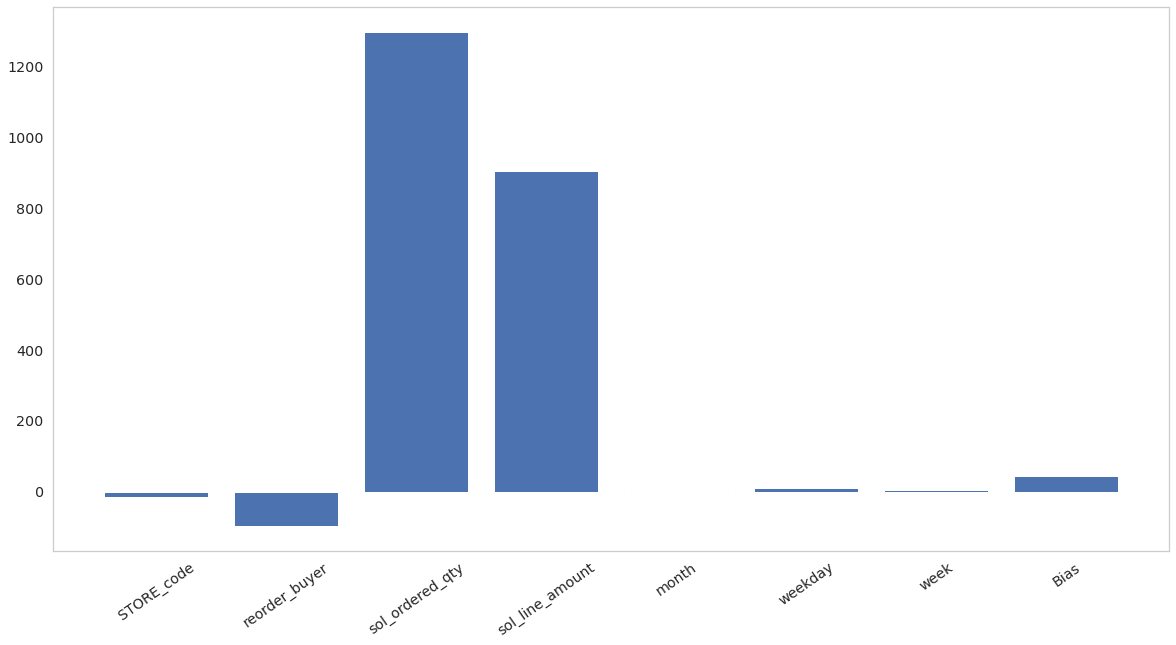

In [140]:
#%% plot coeficientes
plt.figure(figsize=(20,10))
plt.bar(range(d+1), np.concatenate((w,[b])))
labels = labels
plt.xticks(range(w.shape[0]+1), labels, rotation=35)
plt.grid()


(Text(0.5, 0, 'valores reales'), Text(0, 0.5, 'Valores predichos'))

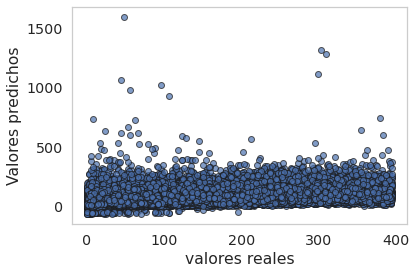

In [118]:
#%% Plot valores esperados vs valores predichos
plt.figure()
plt.scatter(y, y_predict,alpha=0.7, edgecolor='k'), plt.grid()
plt.xlabel("valores reales"), plt.ylabel("Valores predichos")

# Quinto Modelo: Red neuronal

https://www.kaggle.com/enolac5/time-series-arima-dnn-xgboost-comparison/notebook#DNN-Model

In [171]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style(theme='chesterish')

from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

"""from pyramid.arima import auto_arima #auto ARIMA model (pip install pyramid-arima)"""
import xgboost as xgb #xgboost model
import tensorflow as tf #DNN estimator model

In [145]:
df_small_2.head()

,STORE_code,reorder_buyer,so_order_date,sol_ordered_qty,sol_line_amount,dif_order_deliver,month,weekday,week
0,5,7,2018-01-01,2,80.0,188.0,1,0,1
1,5,27,2018-01-01,3,948.0,188.0,1,0,1
2,10,32,2018-01-01,1,399.0,10.0,1,0,1
4,39,7,2018-01-01,1,76.0,26.0,1,0,1
5,39,21,2018-01-01,3,1138.0,31.0,1,0,1


In [148]:
df_small_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197203 entries, 0 to 248223
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   STORE_code         197203 non-null  int64         
 1   reorder_buyer      197203 non-null  category      
 2   so_order_date      197203 non-null  datetime64[ns]
 3   sol_ordered_qty    197203 non-null  Int64         
 4   sol_line_amount    197203 non-null  float64       
 5   dif_order_deliver  197203 non-null  float64       
 6   month              197203 non-null  int64         
 7   weekday            197203 non-null  int64         
 8   week               197203 non-null  int64         
dtypes: Int64(1), category(1), datetime64[ns](1), float64(2), int64(4)
memory usage: 13.9 MB


In [189]:
df = df_small_2[['so_order_date', 'STORE_code', 'reorder_buyer', 'sol_ordered_qty']]

In [190]:
df.head()

,so_order_date,STORE_code,reorder_buyer,sol_ordered_qty
0,2018-01-01,5,7,2
1,2018-01-01,5,27,3
2,2018-01-01,10,32,1
4,2018-01-01,39,7,1
5,2018-01-01,39,21,3


In [191]:
df = df.set_index('so_order_date')
df.index.name = 'date'

In [179]:
df.tail()

,STORE_code,reorder_buyer,sol_ordered_qty
date,,,
2021-11-30,60,21,1
2021-11-30,60,22,12
2021-11-30,60,27,1
2021-11-30,60,34,2
2021-11-30,60,39,5


Renombramos variables

In [192]:
df = df.rename(columns = {'STORE_code': 'store', 'reorder_buyer' : 'item', 'sol_ordered_qty': 'sales'})

In [193]:
df.head()

,store,item,sales
date,,,
2018-01-01,5,7,2
2018-01-01,5,27,3
2018-01-01,10,32,1
2018-01-01,39,7,1
2018-01-01,39,21,3


In [194]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()

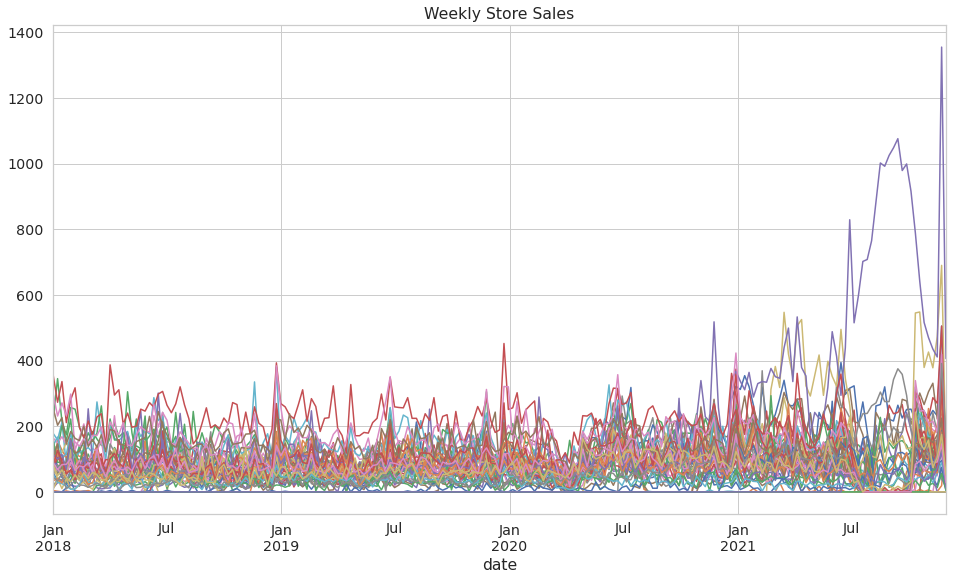

In [200]:
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

In [196]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

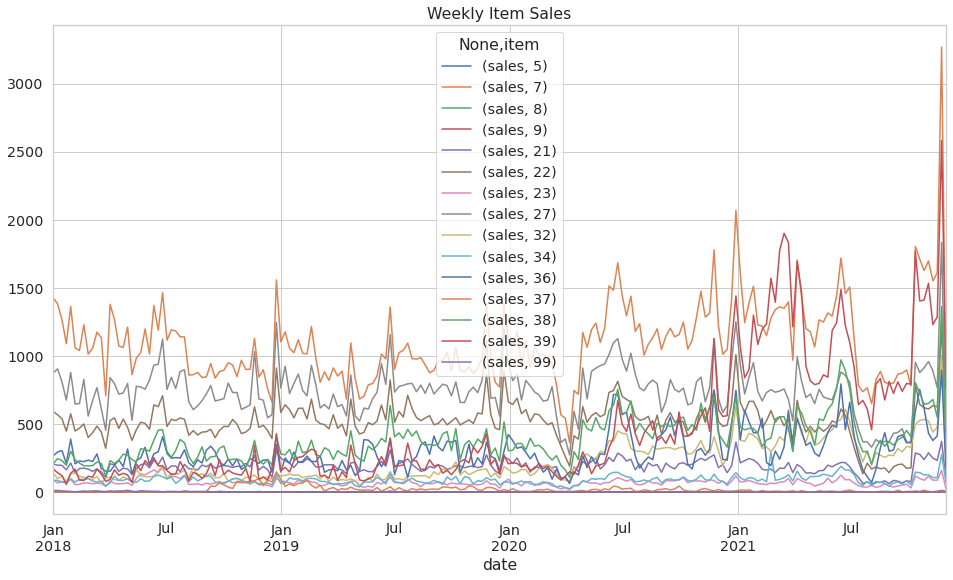

In [198]:
items.plot(figsize=(16,9), title='Weekly Item Sales')
plt.show()

In [ ]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()

In [210]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])).transpose()

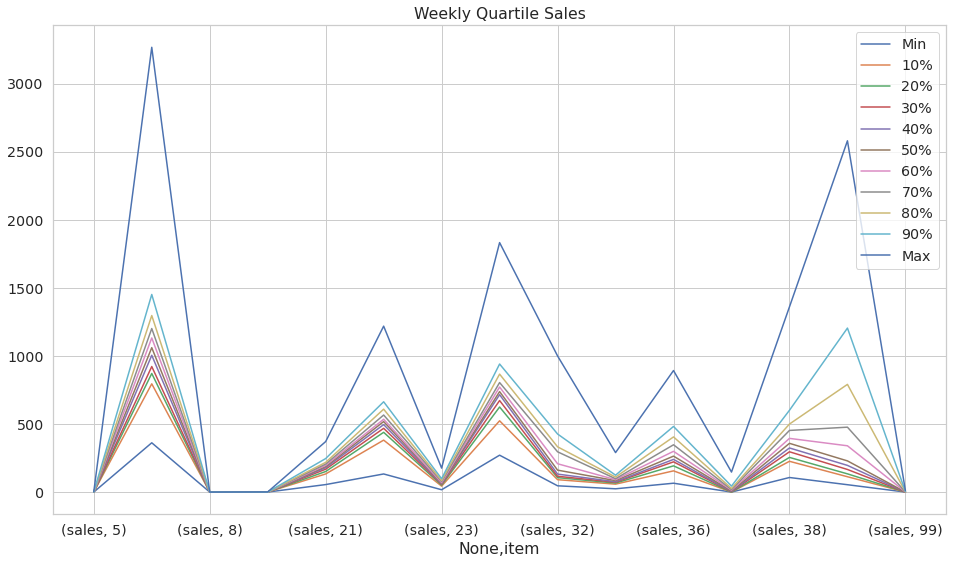

In [211]:
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

In [220]:
ns_per_day = 86400000000000
start_date = pd.to_datetime('January 1, 2020')

In [214]:
fitted_items_WK = []
qtr_list = [0] *11

for column in items:
    for c in range(11):
        qtr_list[c] = [fdt.fastdtw(items[column],item_WK_qtr.iloc[:,c], dist= euclidean)[0], c]
    qtr_list.sort()
    fitted_items_WK.append([column[1], qtr_list[0][1], qtr_list[0][0]])